The basic idea is to use the labelled data in the SEAVIEW images to determine if the unsuperivsed classification algorithm is functioning in a desirable way.  For example, do all of the pixels with a particular class represent the same coral type?

In [32]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [33]:
!pwd

/Users/Mark/fruitpunch/coral_detection/notebooks


In [34]:
!ls ../data

14007262601.jpg                  34006105201.jpg
14007262601_colour_corrected.jpg 34008200601.jpg
14007262601_labels.png           annotations_PAC_AUS.csv
34006089701.jpg


In [35]:
image_path = '/Users/Mark/fruitpunch/coral_detection/data/'
image_file = '14007262601.jpg'

In [36]:
# colour correction using CLAHE algorithm

bgr = cv2.imread(image_path + image_file)

lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)

lab_planes = cv2.split(lab)

# clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
clahe = cv2.createCLAHE()

lab_planes[0] = clahe.apply(lab_planes[0])

lab = cv2.merge(lab_planes)

bgr_col_corr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

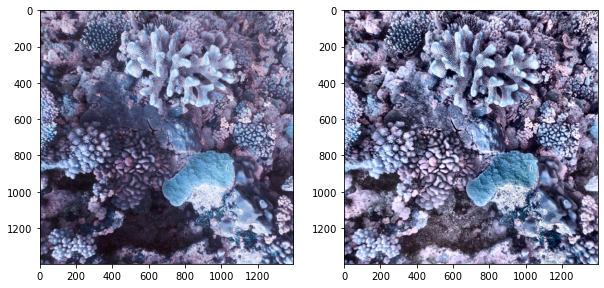

In [37]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(bgr);
ax[1].imshow(bgr_col_corr);

In [38]:
new_image = image_file.split('.')[0] + '_colour_corrected.' + image_file.split('.')[1]

In [39]:
plt.imsave(image_path + new_image, bgr_col_corr)
print("wrote: " + image_path + new_image)

wrote: /Users/Mark/fruitpunch/coral_detection/data/14007262601_colour_corrected.jpg


In [40]:
# run the segmentation algorithm
# https://github.com/kanezaki/pytorch-unsupervised-segmentation-tip

segmentation_script = "/Users/Mark/fruitpunch/coral_detection/pytorch-unsupervised-segmentation-tip/demo.py"
segmentation_options = "--nChannel 7 --maxIter 10 --visualize 1"

!python {segmentation_script} {segmentation_options} --input {image_path + new_image}

/Users/Mark/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
0 / 10 |  label num : 7  | loss : 2.3597183227539062
1 / 10 |  label num : 7  | loss : 1.7573013305664062
2 / 10 |  label num : 7  | loss : 1.4579418897628784
3 / 10 |  label num : 7  | loss : 1.3885871171951294
4 / 10 |  label num : 7  | loss : 1.2993839979171753
5 / 10 |  label num : 7  | loss : 1.2451539039611816
6 / 10 |  label num : 6  | loss : 1.2061564922332764
7 / 10 |  label num : 6  | loss : 1.1353890895843506
8 / 10 |  label num : 6  | loss : 1.0635526180267334
9 / 10 |  label num : 6  | loss : 0.9737571477890015


In [41]:
# move output raster to data folder
!mv /Users/Mark/fruitpunch/coral_detection/notebooks/output.png /Users/Mark/fruitpunch/coral_detection/data/

In [42]:
# rename the output raster
image_labels = image_file.split('.')[0] + '_labels.png'
!mv /Users/Mark/fruitpunch/coral_detection/data/output.png {image_path + image_labels}

In [43]:
!ls ../data

14007262601.jpg                  34006105201.jpg
14007262601_colour_corrected.jpg 34008200601.jpg
14007262601_labels.png           annotations_PAC_AUS.csv
34006089701.jpg


Now read in the annotation file

In [44]:
annot_file = 'annotations_PAC_AUS.csv'

In [45]:
df = pd.read_csv(image_path + annot_file, index_col=0)

In [46]:
# choose only the rows corresponding to our image
id = os.path.basename(image_file).rstrip('.jpg')
id = int(id)
df = df.loc[id]

In [47]:
# analyze by functional group or label name

#category = category
category = 'func_group'

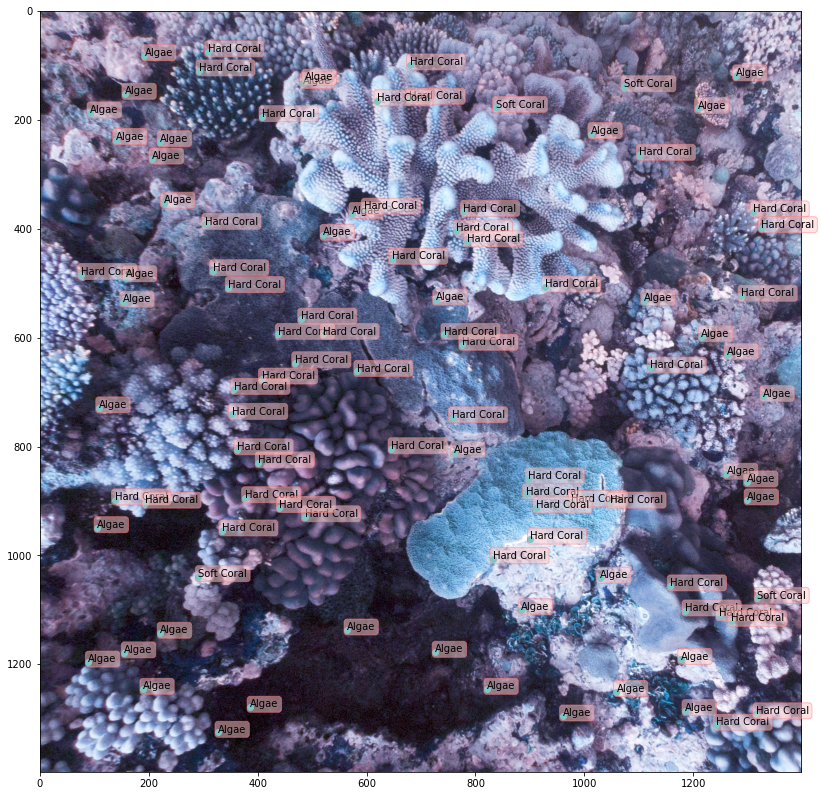

In [48]:
fig, ax = plt.subplots(1,1, figsize=(14,14))
ax.imshow(bgr);
ax.scatter(df["x"], df["y"], color="c");
for k, s in enumerate(df[category]):
  x = df["x"].iloc[k]
  y = df["y"].iloc[k]
  plt.text(x, y, s, color='k', fontsize=10, 
           bbox=dict(boxstyle="round", 
                     ec=(1., 0.5, 0.5),
                     fc=(1., 0.8, 0.8),
                     alpha=0.5))

In [49]:
# read in the labels file.  the 0 flag means read into a single channel (instead of rgb)
lbls = cv2.imread(image_path + image_labels, 0)

In [50]:
np.unique(lbls)

array([ 79, 102, 106, 192, 193, 219], dtype=uint8)

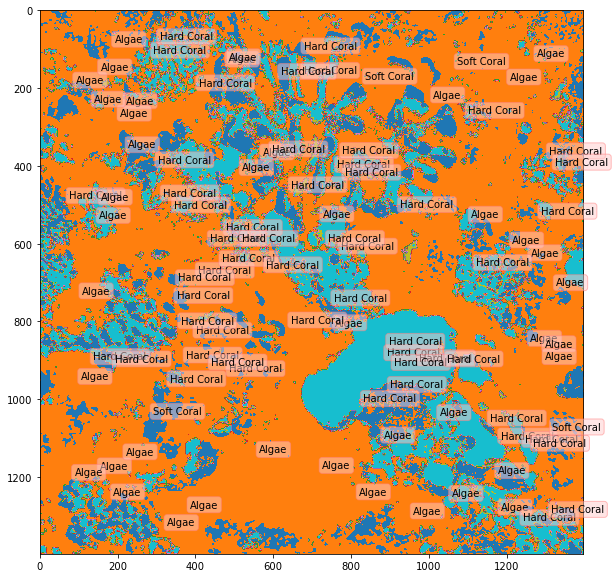

In [51]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(lbls, cmap=plt.get_cmap('tab10'))
for k,s in enumerate(df[category]):
  x = df["x"].iloc[k]
  y = df["y"].iloc[k]
  plt.text(x, y, s, color='k', fontsize=10, 
           bbox=dict(boxstyle="round", 
                     ec=(1., 0.5, 0.5),
                     fc=(1., 0.8, 0.8),
                     alpha=0.5))

In [52]:
df[category].unique()

array(['Hard Coral', 'Algae', 'Soft Coral'], dtype=object)

In [53]:
# setup a dictionary that contains all of the image x,y coordinates for each label name
coral_coords = dict.fromkeys(df[category].unique().tolist())

for lbl in df[category].unique():
    ind = df[category] == lbl
    coral_coords[lbl] = df.loc[ind,('x','y')].to_numpy()

In [54]:
# initialize new column for the cluster number / classification
df['cluster'] = int(0)

In [55]:
# extract the unsupervised algorithm cluster number from each labelled pixel
for label_name, coords in coral_coords.items():
    x = coords[:,0]
    y = coords[:,1]
    cluster_number = lbls[x, y]
    
    ind = df[category] == label_name
    df.loc[ind,'cluster'] = cluster_number

In [56]:
df.head()

,y,x,label_name,label,func_group,method,data_set,cluster
quadratid,,,,,,,,
14007262601,676,407,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,106
14007262601,614,775,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,106
14007262601,970,901,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,219
14007262601,888,892,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,219
14007262601,859,897,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,219


In [77]:
# count up hte occurences
data_to_plot = df.groupby([category, 'cluster'], as_index=True)['cluster'].count()
data_to_plot

func_group  cluster
Algae       79          3
            102        27
            106         5
            193         1
            219         6
Hard Coral  79          9
            102        28
            106         5
            193         3
            219         9
Soft Coral  79          2
            106         2
Name: cluster, dtype: int64

In [78]:
# move multi-index labels into columns
data_to_plot = data_to_plot.reset_index(level=category)
data_to_plot.rename(columns={'cluster':'count'}, inplace=True)
data_to_plot['cluster'] = data_to_plot.index
data_to_plot.reset_index(inplace=True, drop=True)
data_to_plot

,func_group,count,cluster
0,Algae,3,79
1,Algae,27,102
2,Algae,5,106
3,Algae,1,193
4,Algae,6,219
5,Hard Coral,9,79
6,Hard Coral,28,102
7,Hard Coral,5,106
8,Hard Coral,3,193
9,Hard Coral,9,219


In [79]:
coral_coords.keys()

dict_keys(['Hard Coral', 'Algae', 'Soft Coral'])

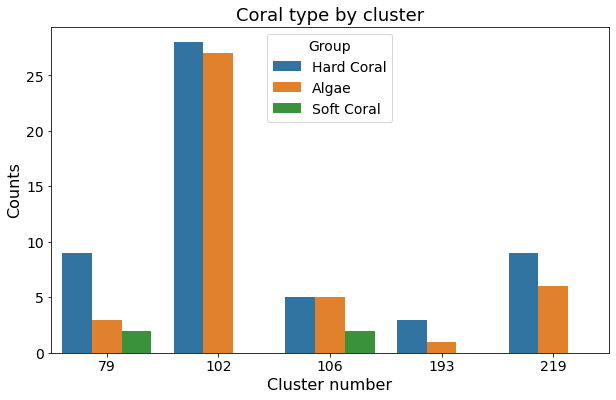

In [86]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.barplot(data=data_to_plot, x='cluster', y='count', hue=category, hue_order=list(coral_coords.keys()), ax=ax);
ax.set_title('Coral type by cluster', size=18);
ax.set_ylabel('Counts',size=16);
ax.set_xlabel('Cluster number', size=16);
ax.tick_params(labelsize=14);
ax.legend(title="Group", fontsize=14, title_fontsize=14);

In [87]:
np.unique(df[category])

array(['Algae', 'Hard Coral', 'Soft Coral'], dtype=object)

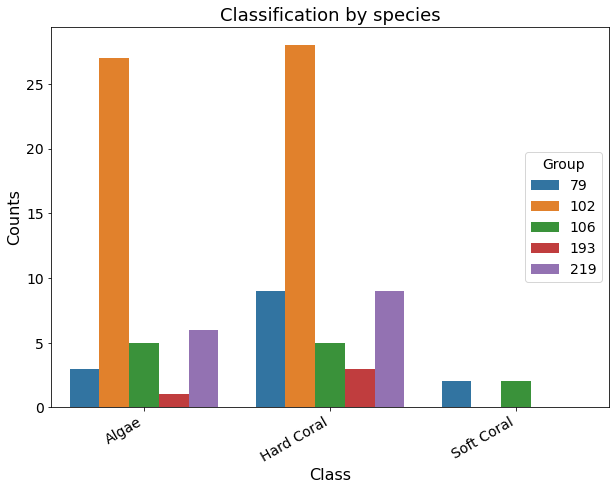

In [92]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.barplot(ax=ax, data=data_to_plot, x=category, y='count', hue='cluster', 
            hue_order=np.unique(data_to_plot['cluster']));
ax.set_title('Classification by species', size=18);
ax.set_ylabel('Counts',size=16);
ax.set_xlabel('Class', size=16);
ax.tick_params(labelsize=14);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right');
ax.legend(title="Group", fontsize=14, title_fontsize=14, loc=5);

In [96]:
# fig, ax = plt.subplots(1,1, figsize=(10,10))
# ax.imshow(lbls, cmap=plt.get_cmap('tab10'))
# ax.scatter(coral_coords['Pocilloporidae'][:,0], coral_coords['Pocilloporidae'][:,1],c='k')
# for x, y in coral_coords['Pocilloporidae']:
#     plt.text(x, y, 'Pocilloporidae', color='k', fontsize=10, 
#              bbox=dict(boxstyle="round", 
#                        ec=(1., 0.5, 0.5),
#                        fc=(1., 0.8, 0.8),
#                        alpha=0.5))

In [97]:
# ind = df['func_group'] == 'Algae'
# ind = ind | (df[category] == 'Epilithic Algal Matrix')
# df.loc[ind,[category,'func_group']]